In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime as dt

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

['../metrics/2025-07-09_09-52-21_metrics.csv', '../metrics/2025-07-10_14-19-18_metrics.csv', '../metrics/2025-07-10_14-22-10_metrics.csv', '../metrics/2025-07-11_08-31-07_metrics.csv', '../metrics/2025-07-11_08-33-43_metrics.csv', '../metrics/2025-07-11_09-12-35_metrics.csv']
timestamp    2025-07-09T09:51:59+00:00
field                   fragments_sent
value                              0.0
node                            node_0
Name: 1, dtype: object


[0.001      0.00242978 0.00590384 0.01434503 0.03485528 0.0846907
 0.20577986 0.5       ]
8
[np.float64(29.268757581710812), np.float64(38.39942932128906), np.float64(48.57884383201599), np.float64(63.49082589149475), np.float64(64.23046016693115), np.float64(66.81489729881287), np.float64(67.95142030715942), np.float64(68.2221622467041)]


/tmp/ipykernel_68145/2671039265.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


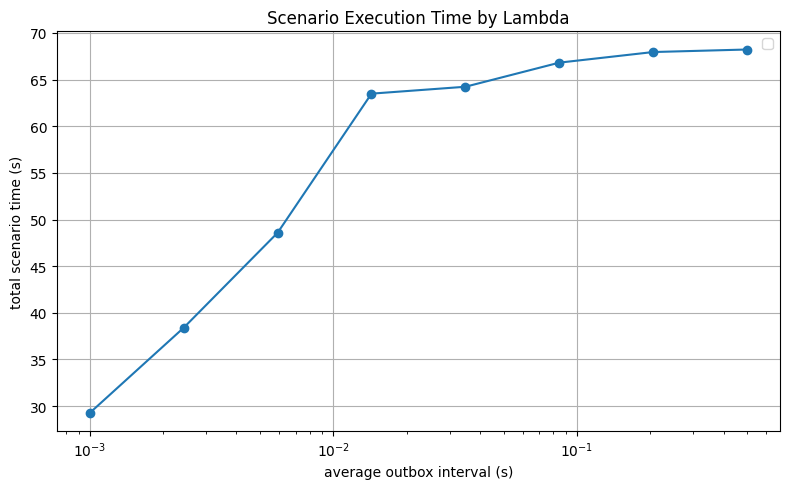

In [12]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

lambdas = np.logspace(np.log10(0.001), np.log10(0.5), num=8)
print(lambdas)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df):
    filtered_df = df.loc[df['field'] == "round_time"]
    return filtered_df['value'].max()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df) for df in df_rt_files]
print(len(rt_list))
print(rt_list)

plt.figure(figsize=(8, 5))           # Optional: set figure size
plt.plot(lambdas[:len(rt_list)], rt_list, marker='o')

# Add labels and title
plt.xlabel('average outbox interval (s)')
plt.xscale('log')
plt.ylabel('total scenario time (s)')
plt.title('Scenario Execution Time by Lambda')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(join(figure_path, "time-per-scenario.png"))
plt.show()


In [13]:
# CPU utilization per state (training, waiting, aggregating, broadcasting)
# y: Total CPU time per stage
# x:
#   - number of batches     
#   - number of nodes       
#   - number of hops        


nr_batches  = [10, 50, 100, 500]
nr_nodes    = [2, 4, 6, 8, 10]
nr_hops     = [1, 2, 3, 4, 5, 6]

stages = {1: "Training", 3: "Broadcasting and Receiving"}
    

def stage_plot(property, title, folder):
    cpu_files = get_filenames_in_folder(join(metrics_path, "cpu_per_stage", folder))
    df_cpu_files = [read_file(f) for f in cpu_files]

    def get_cpu_per_stage(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

        stage_df = df[df['field'] == 'stage'].copy()
        stage_df = stage_df.sort_values('timestamp')
        stage_df = (
            df[df['field'] == 'stage']
            .sort_values('timestamp')
            .groupby(['value', 'node'], as_index=False)
            .last()
        )
        stage_df = stage_df[stage_df['value'].isin(stages.keys())]

        cpu_df = df[df['field'] == 'cpu_total_ns'].copy()
        cpu_df = cpu_df.sort_values('timestamp')

        results = []

        for _, stage_row in stage_df.iterrows():
            stage_time = stage_row['timestamp']
            stage_num = int(stage_row['value'])
            node = stage_row['node']

            cpu_before_stage = cpu_df[(cpu_df['node'] == node) & (cpu_df['timestamp'] <= stage_time)]

            if not cpu_before_stage.empty:
                latest_cpu = cpu_before_stage.iloc[-1]  # last (latest) row
                results.append({
                    'node': node,
                    'stage': stage_num,
                    'cpu_total_ns': float(latest_cpu['value']),
                    'timestamp': latest_cpu['timestamp']
                })

        cpu_per_stage_df = pd.DataFrame(results)

        cpu_per_stage_df = cpu_per_stage_df.sort_values(['node', 'stage'])

        cpu_per_stage_df['cpu_per_stage'] = cpu_per_stage_df.groupby('node')['cpu_total_ns'].diff().fillna(cpu_per_stage_df['cpu_total_ns'])

        return cpu_per_stage_df

    for df in df_cpu_files:
        get_cpu_per_stage(df)

    cpu_values_per_batch = []

    for df in df_cpu_files:
        stage_df = get_cpu_per_stage(df)

        stage_totals = stage_df.groupby('stage')['cpu_per_stage'].mean()

        cpu_row = [stage_totals.get(stage, 0) for stage in stages.keys()]
        cpu_values_per_batch.append(cpu_row)
        
    property = property[:len(cpu_values_per_batch)]

    data = np.array(cpu_values_per_batch)

    x = np.arange(len(property))
    width = 0.2

    plt.figure(figsize=(8, 5))

    for i, stage in enumerate(stages):
        plt.bar(x + i * width, data[:, i], width=width, label=stages[stage])

    plt.xticks(x + width, property)
    plt.xlabel(title)
    plt.ylabel('CPU Ns')
    plt.title('CPU Usage per Stage, ' + title)
    plt.legend(title='Stage')
    plt.savefig(join(figure_path, f"cpu_per_stage_{folder}.png"))
    plt.tight_layout()

    plt.show()

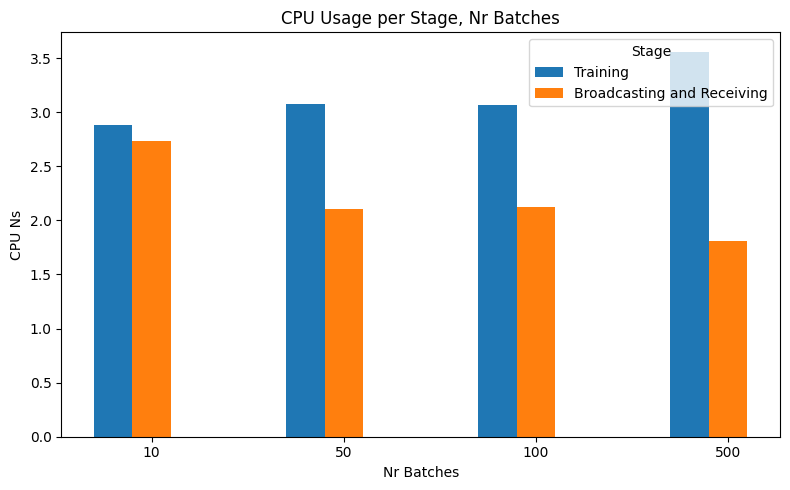

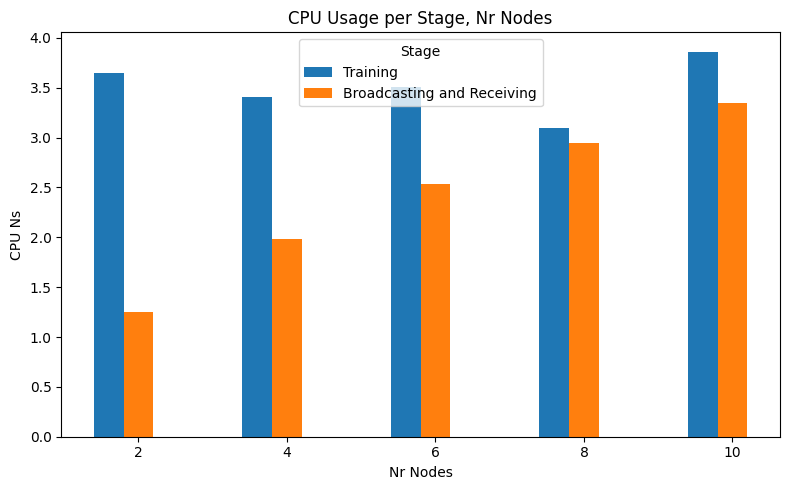

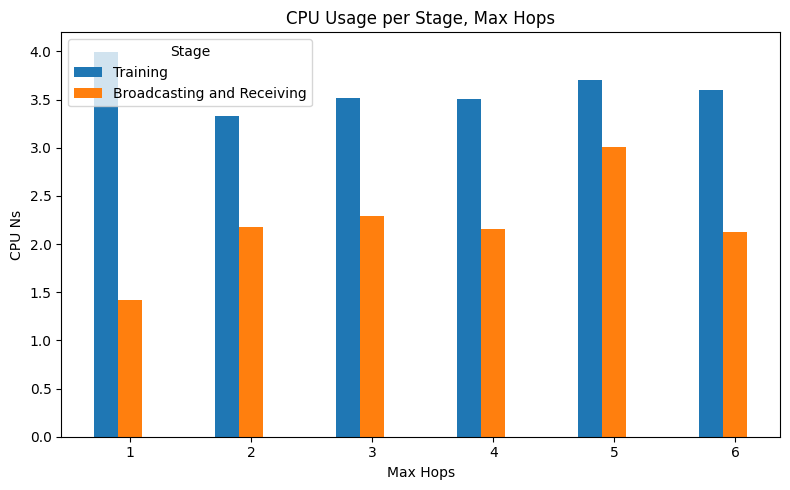

In [10]:
stage_plot(nr_batches, "Nr Batches", "nr_batches")
stage_plot(nr_nodes, "Nr Nodes", "nr_nodes")
stage_plot(nr_hops, "Max Hops", "max_hops")

In [13]:
# y: RTT
# x:
#   - delay in seconds
#   - number of hops

lambdas     = np.logspace(np.log10(0.001), np.log10(0.5), num=8)
print(lambdas)
nr_hops     = [1, 2, 3, 4, 5, 6]

def get_avg_rtt(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    max_peers = df[df['field'] == "active_peers"]['value'].max()
    print(max_peers)
    df_max_peers = df[(df['field'] == "active_peers") & (df['value'] == max_peers)]
    start = df_max_peers['timestamp'].min() + pd.Timedelta(seconds=1)
    end = df_max_peers['timestamp'].max() - pd.Timedelta(seconds=1)

    df_interval = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    rtt_per_node = df_interval[df_interval['field'] == "last_rtt"].groupby('node')
    return rtt_per_node['value'].mean()

def plot_avg_rtt(x_axis, title, folder, image_name, log=False):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    y_axis = [get_avg_rtt(df) for df in df_files]

    plt.figure(figsize=(8, 5))
    plt.plot(x_axis[:len(y_axis)], y_axis, marker='o')

    # Add labels and title
    plt.xlabel(title)
    if log==True:
        plt.xscale('log')
    plt.ylabel('Average RTT (s)')
    plt.title(f'RTT by {title}')

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(join(figure_path, f"{image_name}.png"))
    plt.show()


[0.001      0.00242978 0.00590384 0.01434503 0.03485528 0.0846907
 0.20577986 0.5       ]


3.0


/tmp/ipykernel_227004/4029578104.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


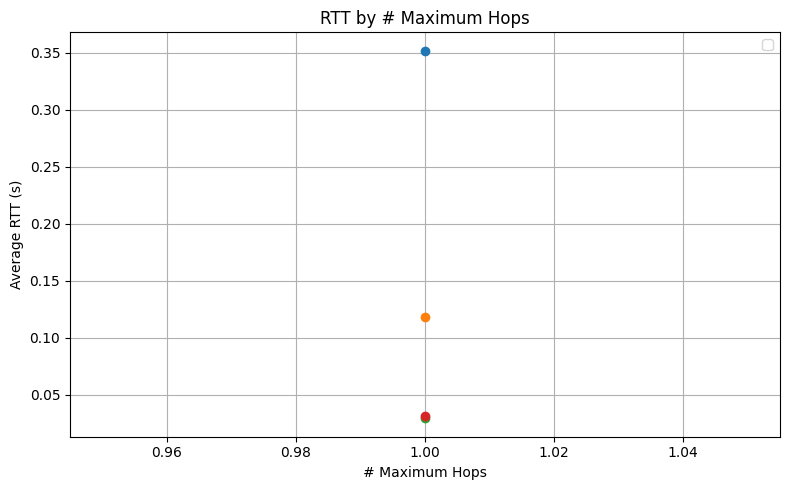

In [14]:
# plot_avg_rtt(lambdas, "Avg Delay (s)", "rtts_per_lambda/no_training", "rtts_per_lambda_no_training", log=True)
plot_avg_rtt(nr_hops, "# Maximum Hops", "rtts_per_hops/last_rtt", "rtts_per_hops_last_rtt")